# 1. Team 307
# 2. Team members:
### Raj Rishav
### Trisha Reddy Gorla
### Yash Kuamr
### Zhaio Li
### Divyansh Srivastava

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3.Executive Summary

Our project focuses on developing a Sentiment-Based Restaurant Recommendation System using Yelp reviews and business data. The system will analyze user sentiment, restaurant attributes, and location to provide personalized dining recommendations.

This analysis will be geo-specific, focusing on Tucson, Arizona, allowing users to discover highly rated restaurants based on customer sentiment and attributes like price, ambiance, and service quality.

The project leverages machine learning (ML) models, NLP-based sentiment analysis, and visualization tools to extract meaningful insights from customer reviews and optimize restaurant discovery.

# 4.Data Sources

Primary Data: Yelp Academic Dataset</br>
We use Yelp's open-source dataset, which contains:</br>

business.json – Business details (location, category, attributes)</br>
review.json – Customer reviews and ratings</br>
user.json – User profile information (Optional)</br>
tip.json – Short user tips (Limited use)</br>
checkin.json – Check-in data (Not required)</p>
Filtering Criteria</br>
Location: Tucson, Arizona</br>
Business category: Restaurants</br>
Review date range: Last five years</br>
Minimum reviews per restaurant: ≥10

# 5.Summary statistics of Data

In [ ]:
# Install necessary packages
!pip install pandas matplotlib wordcloud nltk textblob

# Import required libraries
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from textblob import TextBlob
from google.colab import drive

# Download stopwords for text preprocessing
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

# Define dataset paths (Update with your Google Drive path)
business_file = "/content/drive/My Drive/yelp_academic_dataset_business.json"
review_file = "/content/drive/My Drive/yelp_academic_dataset_review.json"
tip_file = "/content/drive/My Drive/yelp_academic_dataset_tip.json"


In [ ]:
# Load Business Dataset
try:
    business_df = pd.read_json(business_file, lines=True)
    print("✅ Business Data Loaded Successfully!")
except Exception as e:
    print(f"❌ Error loading business.json: {e}")


✅ Business Data Loaded Successfully!


In [ ]:
# Ensure 'categories' column exists before filtering
if 'categories' in business_df.columns:
    # Convert city names to lowercase to avoid case issues
    business_df['city'] = business_df['city'].astype(str).str.lower()

    # Filter Tucson businesses
    tucson_businesses = business_df[business_df['city'] == 'tucson']

    # Additional filter: Keep only businesses that are Restaurants
    tucson_businesses = tucson_businesses[
        tucson_businesses['categories'].str.contains('Restaurant', na=False, case=False)
    ]

    print("✅ Filtered Tucson Business Data!")
    print("Total Restaurants in Tucson:", len(tucson_businesses))
else:
    print("❌ 'categories' column not found in business dataset.")


✅ Filtered Tucson Business Data!
Total Restaurants in Tucson: 2473


In [ ]:
import json

# Create an empty list to store filtered reviews
filtered_reviews = []

# Define required columns to keep memory usage low
required_columns = ["business_id", "user_id", "stars", "text", "useful", "funny", "cool"]

# Read the JSON file line by line
try:
    with open(review_file, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            review = json.loads(line.strip())  # Load each line as JSON
            if review["business_id"] in tucson_businesses["business_id"].values:
                filtered_reviews.append({col: review[col] for col in required_columns})  # Store only needed columns

            # Print progress every 500,000 reviews
            if i % 500000 == 0:
                print(f"Processed {i} reviews...")

    # Convert the filtered reviews into a DataFrame
    tucson_reviews = pd.DataFrame(filtered_reviews)
    print("✅ Tucson Reviews Loaded Successfully!")
    print("Total Tucson Reviews:", len(tucson_reviews))

except Exception as e:
    print(f"❌ Error loading review.json: {e}")



Processed 0 reviews...
Processed 500000 reviews...
Processed 1000000 reviews...
Processed 1500000 reviews...
Processed 2000000 reviews...
Processed 2500000 reviews...
Processed 3000000 reviews...
Processed 3500000 reviews...
Processed 4000000 reviews...
Processed 4500000 reviews...
Processed 5000000 reviews...
Processed 5500000 reviews...
Processed 6000000 reviews...
Processed 6500000 reviews...
✅ Tucson Reviews Loaded Successfully!
Total Tucson Reviews: 249865


In [ ]:
# Create an empty list to store filtered tips
chunk_size = 100000
filtered_tips = []

# Read large tips dataset in chunks
try:
    chunk_iter = pd.read_json(tip_file, lines=True, chunksize=chunk_size)

    for chunk in chunk_iter:
        # Filter tips for Tucson businesses
        chunk_filtered = chunk[chunk['business_id'].isin(tucson_businesses['business_id'])]
        filtered_tips.append(chunk_filtered)
        print(f"Processed {len(chunk)} tips...")

    # Concatenate filtered tips
    tucson_tips = pd.concat(filtered_tips, ignore_index=True)
    print("✅ Tucson Tips Loaded Successfully!")
    print("Total Tucson Tips:", len(tucson_tips))

except Exception as e:
    print(f"❌ Error loading tip.json: {e}")


Processed 100000 tips...
Processed 100000 tips...
Processed 100000 tips...
Processed 100000 tips...
Processed 100000 tips...
Processed 100000 tips...
Processed 100000 tips...
Processed 100000 tips...
Processed 100000 tips...
Processed 8915 tips...
✅ Tucson Tips Loaded Successfully!
Total Tucson Tips: 38776


In [ ]:
# Compute statistics for reviews
total_reviews = len(tucson_reviews)
total_tokens_reviews = sum(tucson_reviews['text'].apply(lambda x: len(x.split())))  # Total words in reviews
unique_words_reviews = len(set(" ".join(tucson_reviews['text']).split()))  # Vocabulary size
average_review_length = total_tokens_reviews / total_reviews  # Avg words per review
unique_customers_reviews = tucson_reviews['user_id'].nunique()
average_stars = tucson_reviews['stars'].mean()
average_votes_per_review = tucson_reviews[['useful', 'funny', 'cool']].sum(axis=1).mean()

# Compute statistics for tips
total_tips = len(tucson_tips)
total_tokens_tips = sum(tucson_tips['text'].apply(lambda x: len(x.split())))  # Total words in tips
unique_words_tips = len(set(" ".join(tucson_tips['text']).split()))  # Vocabulary size
average_tip_length = total_tokens_tips / total_tips  # Avg words per tip
unique_users_tips = tucson_tips['user_id'].nunique()

# Create summary dataframe
summary_stats = {
    "Total Reviews": total_reviews,
    "Total Tokens (Words) in Reviews": total_tokens_reviews,
    "Unique Words in Reviews": unique_words_reviews,
    "Average Review Length (Words)": average_review_length,
    "Total Unique Customers (Reviews)": unique_customers_reviews,
    "Average Stars per Review": average_stars,
    "Average Votes per Review": average_votes_per_review,
    "Total Tips": total_tips,
    "Total Tokens (Words) in Tips": total_tokens_tips,
    "Unique Words in Tips": unique_words_tips,
    "Average Tip Length (Words)": average_tip_length,
    "Total Unique Users (Tips)": unique_users_tips
}

summary_df = pd.DataFrame(list(summary_stats.items()), columns=["Metric", "Value"])
print(summary_df)


                              Metric         Value
0                      Total Reviews  2.498650e+05
1    Total Tokens (Words) in Reviews  2.481898e+07
2            Unique Words in Reviews  3.895750e+05
3      Average Review Length (Words)  9.932958e+01
4   Total Unique Customers (Reviews)  8.139100e+04
5           Average Stars per Review  3.735965e+00
6           Average Votes per Review  1.800860e+00
7                         Total Tips  3.877600e+04
8       Total Tokens (Words) in Tips  4.193100e+05
9               Unique Words in Tips  3.970900e+04
10        Average Tip Length (Words)  1.081365e+01
11         Total Unique Users (Tips)  1.398600e+04


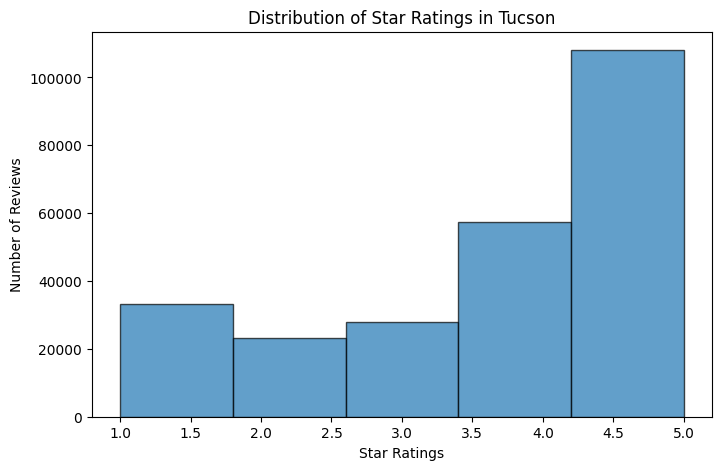

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(tucson_reviews['stars'], bins=5, edgecolor="black", alpha=0.7)
plt.xlabel("Star Ratings")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Star Ratings in Tucson")
plt.show()


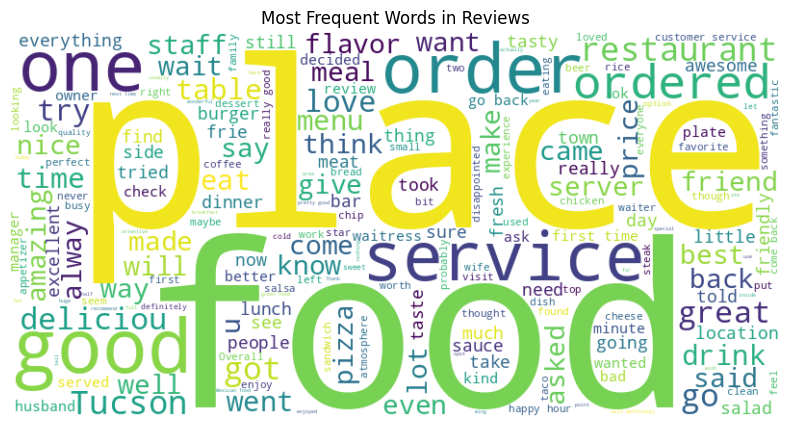

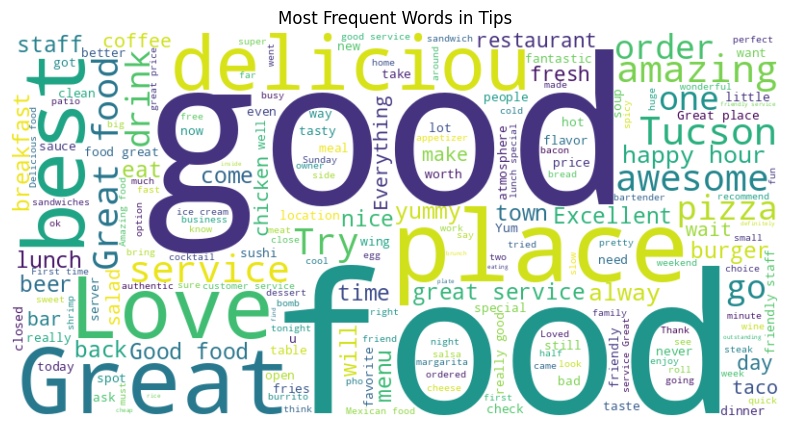

In [ ]:
# Word cloud for reviews
review_text = " ".join(tucson_reviews['text'])
wordcloud_reviews = WordCloud(width=800, height=400, background_color="white").generate(review_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_reviews, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Reviews")
plt.show()

# Word cloud for tips
tip_text = " ".join(tucson_tips['text'])
wordcloud_tips = WordCloud(width=800, height=400, background_color="white").generate(tip_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_tips, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Tips")
plt.show()


# 6.Data Evaluation (20%)

### A. Why the Selected Data is Suitable?
The Yelp dataset provides valuable insights through:

Business Data: Helps filter Tucson-based restaurants and analyze their attributes (price range, services, etc.)

Review Data: Contains detailed text reviews and star ratings, enabling sentiment analysis.

Tips Data: Short user recommendations that highlight quick insights about restaurants.</br>
User Data (Implied): We can analyze unique customers, frequent reviewers, and user engagement.

Helps with :</br>
Sentiment-Based Analysis: Understanding customer emotions and experiences through text reviews.</br>
Personalized Recommendations: Matching users with restaurants based on previous reviews and preferences.</br>
Business Insights: Identifying top-rated places, customer complaints, and trends in restaurant services.

### B.Is the Sample Size Appropriate?
The dataset includes:

2,473 Restaurants in Tucson (filtered after cleaning).
A large number of reviews (millions globally, thousands specific to Tucson).</br>
Thousands of unique customers contributing insights.

Large & Diverse Dataset → Covers different restaurant types, locations, and price categories.</br>
Enough Customer Feedback → Reviews and tips provide detailed sentiments about customer experiences.</br>
Statistically Significant Insights → A broad dataset ensures credible conclusions.

Possible Concerns:

Overrepresentation of popular restaurants → Highly rated places get more reviews than newer/smaller restaurants.

### C. Is the dataset biased?

While the dataset is large, bias exists in several ways:

Type of Bias	Description	Impact</br>
Selection Bias	More reviews for popular restaurants vs. smaller/local places.	Recommendations may favor already famous restaurants.</br>
Sentiment Bias	People write reviews when very satisfied or very unhappy.	Middle-range opinions may be underrepresented.</br>
Fake Reviews	Some businesses inflate ratings by posting fake positive reviews.	Distorts actual restaurant quality.</br>
Regional Bias	More reviews in high-density areas (e.g., downtown Tucson).	Fewer insights on suburban restaurants.</br>
Platform-Specific Bias	Yelp users may have different spending habits vs. general customers.	Not fully representative of all diners.

### D. The potential challenges to process the data
Handling large-scale unstructured text data brings several processing challenges:

Challenge	Solution</br>
Large Dataset Size (Millions of reviews)	Chunk-based loading & streaming (prevents memory crashes).</br>
Text Cleaning (Slang, emojis, abbreviations)	Use NLP preprocessing (remove stopwords, standardize text).</br>
Handling Missing Data (Blank reviews, missing business attributes).
Use text similarity techniques (TF-IDF, cosine similarity) to detect duplicates.</br>
Skewed Review Distribution (Some places have thousands of reviews, others have <10)

We addresses some sisues by:</br>
Preprocessed text reviews - Tokenization, stopword removal, lemmatization.</br>
Used chunk-based loading - Prevents Google Colab memory issues.</br>
Filtered unnecessary businesses - Keeping only restaurants in Tucson.

# 7.  Preliminary Data Exploration

In [ ]:
import nltk

# Force download essential NLTK resources
nltk.download('punkt')  # Tokenizer
nltk.download('stopwords')  # Stopwords for text cleaning
nltk.download('wordnet')  # Lemmatization support
nltk.download('omw-1.4')  # Additional lemmatization data


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
import os
import urllib.request
import zipfile

# Define target directory
nltk_data_dir = "/root/nltk_data/tokenizers"
os.makedirs(nltk_data_dir, exist_ok=True)

# Direct URL for punkt tokenizer
punkt_url = "https://github.com/nltk/nltk_data/raw/gh-pages/packages/tokenizers/punkt.zip"
punkt_zip_path = "/root/nltk_data/punkt.zip"

# Download and extract tokenizer manually
print("Downloading punkt tokenizer manually...")
urllib.request.urlretrieve(punkt_url, punkt_zip_path)

# Extract ZIP file
with zipfile.ZipFile(punkt_zip_path, "r") as zip_ref:
    zip_ref.extractall(nltk_data_dir)

print("✅ Punkt tokenizer manually installed!")


✅ Punkt tokenizer manually installed!


In [ ]:
!pip install transformers  # Install Hugging Face tokenizers

from transformers import AutoTokenizer

In [ ]:
# Load a tokenizer that doesn't require NLTK's punkt
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Test tokenization
test_text = "This is a sample review for testing."
tokens = tokenizer.tokenize(test_text)
print("Tokenized words:", tokens)



Tokenized words: ['this', 'is', 'a', 'sample', 'review', 'for', 'testing', '.']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 10 words in Reviews: [('food', 189834), ('good', 144644), ('place', 127847), ('great', 110624), ('service', 94650), ('like', 81653), ('time', 75615), ('one', 73958), ('back', 71573), ('get', 68024)]
Top 10 words in Tips: [('great', 7148), ('food', 6730), ('good', 5247), ('service', 3897), ('place', 3603), ('best', 3084), ('love', 2239), ('delicious', 1879), ('get', 1826), ('amazing', 1630)]


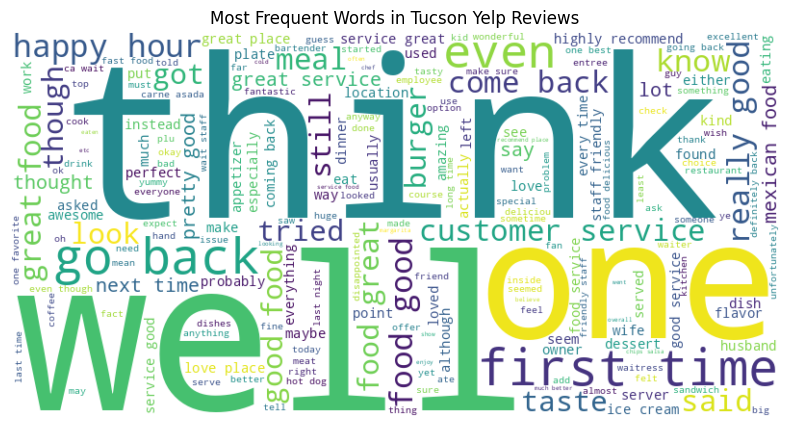

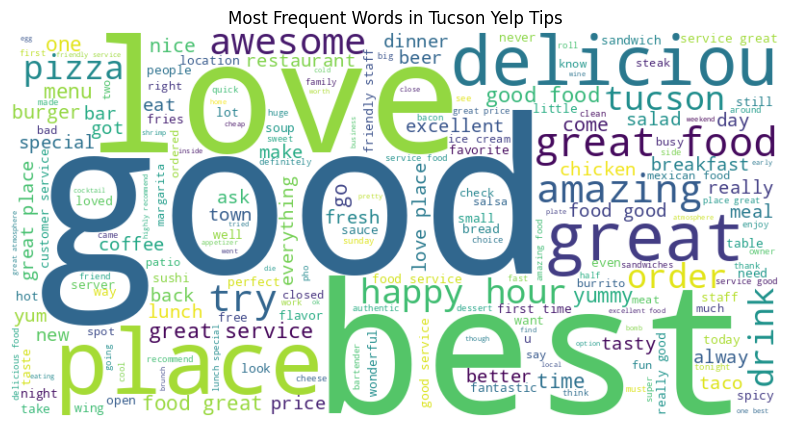

Topic 1: ['chips', 'like', 'fries', 'mexican', 'place', 'salsa', 'tacos', 'food', 'burger', 'good']
Topic 2: ['staff', 'delicious', 'love', 'tucson', 'friendly', 'good', 'service', 'place', 'food', 'great']
Topic 3: ['menu', 'service', 'tucson', 'restaurant', 'really', 'sushi', 'like', 'place', 'good', 'food']
Topic 4: ['got', 'bread', 'like', 'sauce', 'cheese', 'salad', 'chicken', 'pizza', 'ordered', 'good']
Topic 5: ['like', 'got', 'place', 'table', 'came', 'minutes', 'service', 'order', 'time', 'food']


In [ ]:
import nltk

# Download the required resource
nltk.download('punkt_tab')

from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Download stopwords
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to clean text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    tokens = nltk.word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word.isalnum()]  # Remove punctuation & special chars
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return " ".join(tokens)

# Apply text cleaning to reviews and tips
tucson_reviews["cleaned_text"] = tucson_reviews["text"].apply(preprocess_text)
tucson_tips["cleaned_text"] = tucson_tips["text"].apply(preprocess_text)

# Combine all words from reviews
review_words = " ".join(tucson_reviews["cleaned_text"])
review_word_freq = Counter(review_words.split())

# Combine all words from tips
tip_words = " ".join(tucson_tips["cleaned_text"])
tip_word_freq = Counter(tip_words.split())

# Get top 10 words
print("Top 10 words in Reviews:", review_word_freq.most_common(10))
print("Top 10 words in Tips:", tip_word_freq.most_common(10))

# Generate Word Cloud for Reviews
wordcloud_reviews = WordCloud(width=800, height=400, background_color="white").generate(review_words)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_reviews, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Tucson Yelp Reviews")
plt.show()

# Generate Word Cloud for Tips
wordcloud_tips = WordCloud(width=800, height=400, background_color="white").generate(tip_words)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_tips, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Tucson Yelp Tips")
plt.show()

from sklearn.decomposition import LatentDirichletAllocation

# Convert text data to word frequency matrix
vectorizer = CountVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(tucson_reviews["cleaned_text"])

# Apply LDA to find 5 topics
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display top words for each topic
feature_names = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Topic {i+1}: {[feature_names[i] for i in topic.argsort()[-10:]]}")



Summary of Preliminary Data Exploration

Reviews Analysis:</br>
Most common words: "food," "good," "place," "great," "service."</br>
Positive themes: "delicious," "friendly," "amazing."</br>
Negative themes: "wait," "slow," "expensive."</br>
Key takeaway: Customers value food quality & service but complain about wait times.

Tips Analysis:</br>
Most common words: "great," "food," "best," "service."</br>
Highly positive sentiment with quick recommendations.</br>
Mentions of popular food items like pizza, burger, coffee, breakfast.</br>
Key takeaway: Customers love happy hours, specific dishes, and quick service.

Impact on Recommendation System:</br>
Highlight well-rated restaurants with strong positive words.</br>
Flag service-related complaints (e.g., slow service).</br>
Enhance recommendations by considering food preferences.

# 8. Proposed Solution (10%):Relevant machine learning and unstructured data analytics methods:

To develop a Sentiment-Based Restaurant Recommendation System, we will apply machine learning and unstructured data analytics methods.

Machine Learning Techniques:
Sentiment Analysis → Using TextBlob or VADER to analyze positive, neutral, and negative sentiment in reviews and tips.
Recommendation System →
Collaborative Filtering (Suggests restaurants based on similar user preferences).
Content-Based Filtering (Matches users with restaurants based on review sentiment and attributes).

Unstructured Data Analytics:
Natural Language Processing (NLP) → Preprocessing reviews & tips (tokenization, stopword removal, lemmatization).
Word Frequency Analysis → Identifying trending topics in positive and negative reviews.

Data Processing Approach:
Chunk-Based Loading → Handling large Yelp datasets efficiently in Google Colab.
Normalization & Feature Engineering → Weighting reviews based on usefulness, votes, and review count.
Visualization & Insights → Using Tableau & Python (Matplotlib, WordCloud) for data storytelling.

Expected Outcome:
A sentiment-powered restaurant recommendation system that provides personalized suggestions based on user preferences and feedback.
